# CNN Algorithm for dazzled camera identification

In [22]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# import pandas as pd
# from scipy import stats
# import keras.backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout#, RandomFlip, RandomRotation, BatchNormalization, SpatialDropout2D
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical#, plot_model
# from sklearn.preprocessing import RobustScaler, MaxAbsScaler
# from tensorflow.keras.metrics import BinaryCrossentropy as metricBinaryCrossentropy
# from tensorflow.keras.metrics import FalseNegatives, BinaryIoU ,AUC#, F1Score
from tensorflow_addons.metrics import F1Score  # FOR CERTAIN VERSIONS OF TF THIS DOESN'T WORK, USE THE PACKAGE BELOW INSTEAD 
#from tensorflow.keras.metrics import F1Score 
from tensorflow.keras.losses import BinaryCrossentropy#, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Nadam #,schedules
# from tensorflow.image import resize_with_crop_or_pad
# from tensorflow import cast, expand_dims, float32, random
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [23]:
def Max(data_array):
    max = np.max(data_array, axis=1)
    return max

def Amp(data_array):
    amp = np.sum(data_array, axis=1)
    return amp

def Ratio(data_array):
    max = np.max(data_array, axis=1)
    mean = np.mean(data_array, axis=1)
    ratio = 1 - mean/max
    return ratio

In [24]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Import data and MC truth


In [25]:
data_path = './dazzled_cameras_dataset'

# Load Data  
with open(data_path+'/simulation_11.npy', 'rb') as b:    #'+str(sim_num)+'
    data_in_1 = np.load(b)
with open(data_path+'/simulation_22.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_2 = np.load(c)
with open(data_path+'/simulation_33.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_3 = np.load(c)
    
# Load MC Truth
with open(data_path+'/inner_ph_11.npy', 'rb') as f:      #'+str(sim_num)+'
    ph_in_1 = np.load(f)
with open(data_path+'/inner_ph_22.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_2 = np.load(g)
with open(data_path+'/inner_ph_33.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_3 = np.load(g)    

## Exploring the Dataset

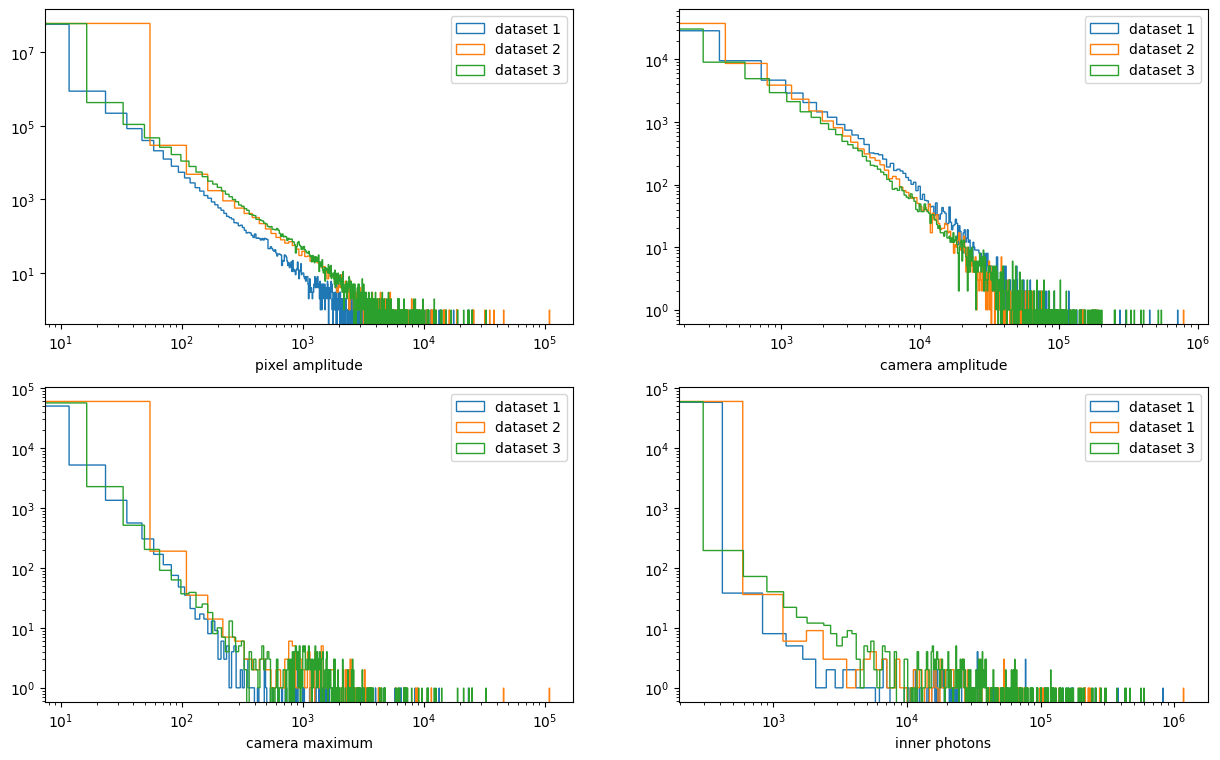

In [26]:
###### fixed parameters ###########
#n_cam_in_grain_0 = 54
n_cam_in_grain_1 = 58
n_cam_in_grain_2 = 60
n_cam_in_grain_3 = 60
cam_side_length = 32
###################################

fig, ax = plt.subplots(2,2)

ax[0,0].hist(data_in_1, 2000, histtype='step', label='dataset 1');
ax[0,0].hist(data_in_2, 2000, histtype='step', label='dataset 2');
ax[0,0].hist(data_in_3, 2000, histtype='step', label='dataset 3');
ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('pixel amplitude')
ax[0,0].legend()

ax[0,1].hist(np.sum(data_in_1.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 1');
ax[0,1].hist(np.sum(data_in_2.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 2');
ax[0,1].hist(np.sum(data_in_3.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 3');
ax[0,1].set_yscale('log')
ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('camera amplitude')
ax[0,1].legend()

ax[1,0].hist(np.max(data_in_1.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 1');
ax[1,0].hist(np.max(data_in_2.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 2');
ax[1,0].hist(np.max(data_in_3.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 3');
ax[1,0].set_yscale('log')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('camera maximum')
ax[1,0].legend()

ax[1,1].hist(ph_in_1[:,0], 2000, histtype='step', label='dataset 1')
ax[1,1].hist(ph_in_2[:,0], 2000, histtype='step', label='dataset 1')
ax[1,1].hist(ph_in_3[:,0], 2000, histtype='step', label='dataset 3')
ax[1,1].set_yscale('log')
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('inner photons')
ax[1,1].legend()

fig.set_figwidth(15)
fig.set_figheight(9)

## Preprocessing

### Concatenating multiple datasets

In [27]:
inner_ph_in_1 = ph_in_1[:,0].reshape(n_cam_in_grain_1, -1)
inner_ph_in_2 = ph_in_2[:,0].reshape(n_cam_in_grain_2, -1)
inner_ph_in_3 = ph_in_3[:,0].reshape(n_cam_in_grain_3, -1)

inner_ratio_11 = ((ph_in_1[:,0])/(ph_in_1[:,1]-(ph_in_1[:,0]))).reshape(n_cam_in_grain_1, -1)
inner_ratio_22 = ((ph_in_2[:,0])/(ph_in_2[:,1]-(ph_in_2[:,0]))).reshape(n_cam_in_grain_2, -1)
inner_ratio_33 = ((ph_in_3[:,0])/(ph_in_3[:,1]-(ph_in_3[:,0]))).reshape(n_cam_in_grain_3, -1)
inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_cam_in_grain_2, -1)
inner_ratio_3 = (ph_in_3[:,0]/ph_in_3[:,1]).reshape(n_cam_in_grain_3, -1)

data_in = np.concatenate((data_in_1.reshape(-1, cam_side_length**2), data_in_2.reshape(-1, cam_side_length**2), data_in_3.reshape(-1, cam_side_length**2))) #new_data_0, 
inner_ph_in = np.concatenate((np.ravel(inner_ph_in_1, order='F'), np.ravel(inner_ph_in_2, order='F'), np.ravel(inner_ph_in_3, order='F')))
inner_ratio = np.concatenate((np.ravel(inner_ratio_11, order='F'), np.ravel(inner_ratio_22, order='F'), np.ravel(inner_ratio_33, order='F')))

inner_ratio[np.isnan(inner_ratio)] = 0

# INCLUDE PIXEL SATURATION
data_in[data_in > 1000] = 1000

C:\Users\Pc\AppData\Local\Temp\ipykernel_24444\1495928500.py:5: RuntimeWarning: invalid value encountered in divide
  inner_ratio_11 = ((ph_in_1[:,0])/(ph_in_1[:,1]-(ph_in_1[:,0]))).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_24444\1495928500.py:6: RuntimeWarning: invalid value encountered in divide
  inner_ratio_22 = ((ph_in_2[:,0])/(ph_in_2[:,1]-(ph_in_2[:,0]))).reshape(n_cam_in_grain_2, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_24444\1495928500.py:7: RuntimeWarning: invalid value encountered in divide
  inner_ratio_33 = ((ph_in_3[:,0])/(ph_in_3[:,1]-(ph_in_3[:,0]))).reshape(n_cam_in_grain_3, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_24444\1495928500.py:8: RuntimeWarning: invalid value encountered in divide
  inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_24444\1495928500.py:9: RuntimeWarning: invalid value encountered in divide
  inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_

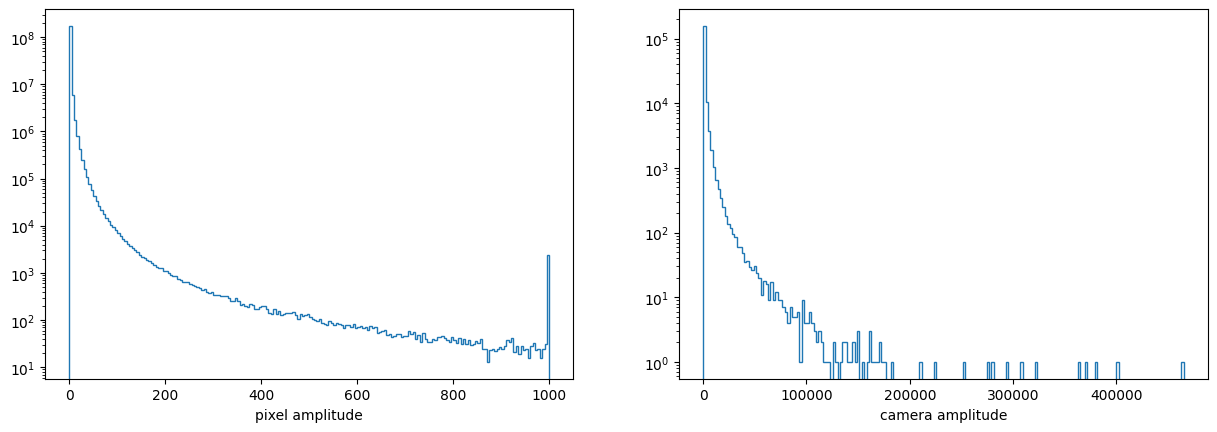

In [28]:
fig, ax = plt.subplots(1,2)
ax[0].hist(data_in.reshape(-1,1), 200, histtype='step',)
ax[0].set_yscale('log')
ax[0].set_xlabel('pixel amplitude')

ax[1].hist(np.sum(data_in, axis=1), 200, histtype='step',)
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')

fig.set_figwidth(15)

### Data labelling

In [29]:
## PARAMETERS ##
ph_threshold = 50           # SET A MINIMUM THRESHOLD FOR THE NUMBER OF PHOTONS PRODUCED INSIDE A CAMERA
ratio_threshold = 0.01      # SET A LOWER BOUND FOR THE RATIO
###########################################################################################################
label = np.zeros(inner_ph_in.shape[0])

for i in np.where( (inner_ratio > ratio_threshold) & (inner_ph_in > ph_threshold) )[0]:
    label[i] = 1
    
n_dazzled = label[label==1].shape[0]
n_not_dazzled = label[label==0].shape[0]
print('labelled-dazzlecameras :', n_dazzled )
print('labelled-non dazzlecameras :', n_not_dazzled )
print('dazzlecameras abundance :', 100*n_dazzled/n_not_dazzled, '%')

labelled-dazzlecameras : 1393
labelled-non dazzlecameras : 176607
dazzlecameras abundance : 0.7887569575384894 %


### Feature Extraction

C:\Users\Pc\AppData\Local\Temp\ipykernel_24444\1876023619.py:12: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


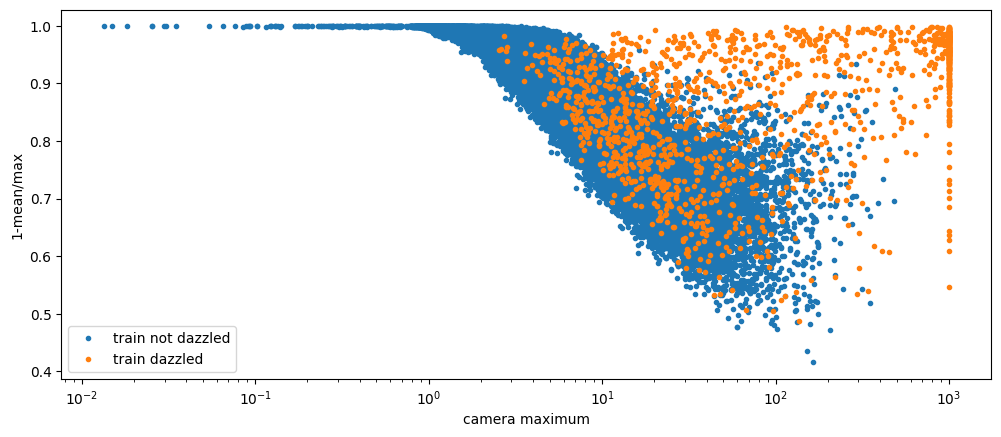

In [30]:
plt.figure().set_figwidth(12)
plt.plot(Max(data_in.reshape(-1, cam_side_length**2))[label == 0], Ratio(data_in.reshape(-1, cam_side_length**2))[label == 0], '.', label='train not dazzled')
plt.plot(Max(data_in.reshape(-1, cam_side_length**2))[label == 1], Ratio(data_in.reshape(-1, cam_side_length**2))[label == 1], '.', label='train dazzled')

plt.xscale('log')
plt.xlabel('camera maximum')
plt.ylabel('1-mean/max')
plt.legend()

### Data Normalization

In [31]:
# normalize_ = np.max(data_in, axis = 1)
# normalize_[np.where(normalize_ == 0)[0]] = 1e-5
normalized_data = (data_in / 1000).reshape(-1, cam_side_length**2)
normalized_data.shape

(178000, 1024)

### Split into test and training sets

In [32]:
sep = int(data_in.shape[0] * 0.8)

train_data, test_data = normalized_data[:sep], normalized_data[sep:]
train_label, test_label = label[:sep], label[sep:]

### Data augmentation for dazzled dataset

In [33]:
train_dazzled = train_data[np.where(train_label==1)]
train_not_dazzled = train_data[np.where(train_label==0)]

rdm = np.random.default_rng(12345)
rdm_x = rdm.integers(low=0, high=31, size=int(0.3*n_not_dazzled))
rdm_y = rdm.integers(low=0, high=31, size=int(0.3*n_not_dazzled))
artificial_train_dazzled = np.repeat(train_dazzled, int(0.3*n_not_dazzled/train_dazzled.shape[0]), axis=0).reshape(-1, cam_side_length, cam_side_length, 1)

for r in range(artificial_train_dazzled.shape[0]) :
    artificial_train_dazzled[r] = np.roll(artificial_train_dazzled[r], (rdm_x[r] ,rdm_y[r]), axis=(2,1))
    
artificial_train_label = np.ones(artificial_train_dazzled.shape[0])

train_data = train_data.reshape(-1, cam_side_length, cam_side_length, 1)
test_data = test_data.reshape(-1, cam_side_length, cam_side_length, 1)

train_data_aug = np.append(artificial_train_dazzled, train_data, axis=0).astype('float32')
train_label_aug = np.append(artificial_train_label, train_label).astype('float32')

train_label_ohe = to_categorical(train_label_aug,2)
test_label_ohe = to_categorical(test_label,2)

## CNN model


In [34]:
#create model
model = Sequential()
#add model layers
model.add(Input(shape=(cam_side_length, cam_side_length, 1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))              
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [35]:
model.compile(optimizer=Nadam(learning_rate=0.001), loss=BinaryCrossentropy(from_logits=False), metrics=[F1Score(num_classes=2)]) 

# Train the model
with tf.device('/CPU:0'):
    history_callback = model.fit(train_data_aug, train_label_ohe, batch_size=256, validation_split=0.25, epochs= 30)

Epoch 1/30
571/571 [==============================] - 74s 124ms/step - loss: 0.2764 - f1_score: 0.8785 - val_loss: 0.1118 - val_f1_score: 0.6381
Epoch 2/30
571/571 [==============================] - 70s 122ms/step - loss: 0.1710 - f1_score: 0.9281 - val_loss: 0.1559 - val_f1_score: 0.5921
Epoch 3/30
571/571 [==============================] - 69s 120ms/step - loss: 0.1396 - f1_score: 0.9432 - val_loss: 0.1194 - val_f1_score: 0.6302
Epoch 4/30
571/571 [==============================] - 70s 122ms/step - loss: 0.1196 - f1_score: 0.9521 - val_loss: 0.1131 - val_f1_score: 0.6298
Epoch 5/30
571/571 [==============================] - 70s 123ms/step - loss: 0.1053 - f1_score: 0.9589 - val_loss: 0.1003 - val_f1_score: 0.6421
Epoch 6/30
571/571 [==============================] - 71s 125ms/step - loss: 0.0976 - f1_score: 0.9617 - val_loss: 0.0974 - val_f1_score: 0.6563
Epoch 7/30
571/571 [==============================] - 72s 126ms/step - loss: 0.0890 - f1_score: 0.9648 - val_loss: 0.0878 - val_f1

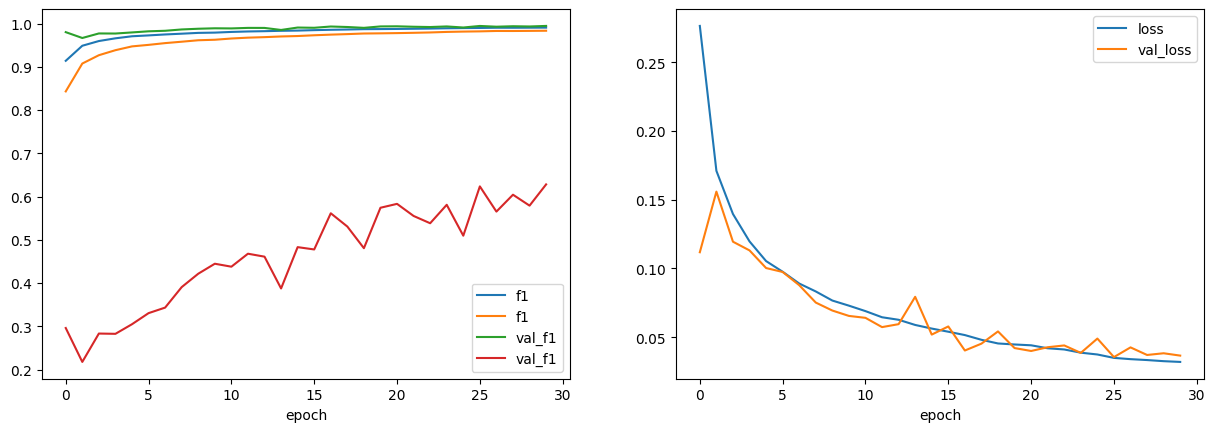

In [36]:
fig, ax = plt.subplots(1,2)
ax[0].plot(history_callback.history['f1_score'], label='f1')
ax[0].plot(history_callback.history['val_f1_score'], label='val_f1')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history_callback.history['loss'], label='loss')
ax[1].plot(history_callback.history['val_loss'], label='val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

fig.set_figwidth(15)

### Performance check

1113/1113 [==============================] - 15s 13ms/step - loss: 0.0562 - f1_score: 0.7938
test_acc: [0.9921395 0.5954311]
1113/1113 [==============================] - 13s 11ms/step
labelled : 547
predicted : 812
true positive : 405
false positive : 407
false negative : 142


confusion matrix :
[[34646   407]
 [  142   405]]
precision : 0.4987684729064039
recall : 0.7404021937842779
f1 score : 0.596026490066225
roc score : 0.8643956023552948


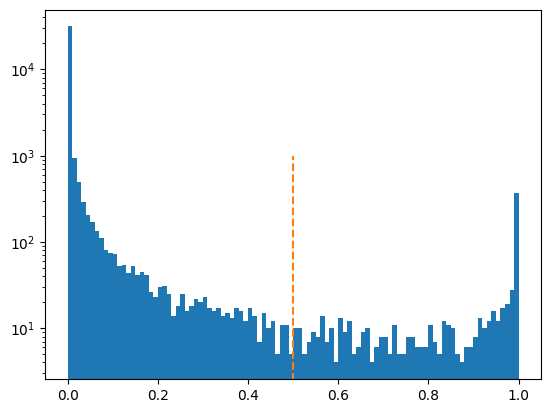

In [37]:
with tf.device('/CPU:0'):
    test_loss, test_acc = model.evaluate(test_data, test_label_ohe)
    print('test_acc:', test_acc)

    pred = model.predict(test_data)

    plt.hist(np.dot(pred, np.array([0,1], dtype='float32')), 100)
    plt.plot([0.5, 0.5],[0,1e3], '--')
    plt.yscale('log')

    pred_lab = np.dot(test_label_ohe, np.array([0,1], dtype='float32'))
    pred_dec = np.dot(np.around(pred), np.array([0,1], dtype='float32'))
    cm = confusion_matrix(pred_lab, pred_dec)
    prec = precision_score(pred_lab, pred_dec)
    reca = recall_score(pred_lab, pred_dec)
    f1 = f1_score(pred_lab, pred_dec)
    roc = roc_auc_score(pred_lab, pred_dec)

print('labelled :', np.where(pred_lab==1)[0].size)  
print('predicted :',  np.where(pred_dec==1)[0].size) 
print('true positive :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)).shape[0])     
print('false positive :', np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)).shape[0])     
print('false negative :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)).shape[0]) 
print('\n')
print('confusion matrix :')
print(cm)
print('precision :', prec)
print('recall :', reca)
print('f1 score :', f1)
print('roc score :', roc)

### Save classified images to pdf (optional)

In [38]:
write_pdf = False # IF YOU WANT TO PRINT PDF, CHANGE TO 'True'

non_scaled = data_in[sep:].reshape(-1, cam_side_length, cam_side_length, 1)
if write_pdf :
    n = 0
    pdf = PdfPages('./PDF_NAME.pdf')  # EDIT THE PDF NAME AS YOU PREFER
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)):
        fig, ax = plt.subplots(1,2)
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length))
        fig.colorbar(matrix0)
        ax[0].set_title('TRUE positive')
        ax[0].set_xlabel('inner ph: '+str(inner_ph_in[sep+evn])+' - ratio: '+str(inner_ratio[sep+evn]))
        matrix1 = ax[1].pcolormesh(np.log(non_scaled[evn].reshape(cam_side_length,cam_side_length)+1))
        fig.colorbar(matrix1)
        ax[1].set_title('TRUE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)):
        fig, ax = plt.subplots(1,2)
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) 
        fig.colorbar(matrix0)
        ax[0].set_title('FALSE positive')
        ax[0].set_xlabel('inner ph: '+str(inner_ph_in[sep+evn])+' - ratio: '+str(inner_ratio[sep+evn]))
        matrix1 = ax[1].pcolormesh(np.log(non_scaled[evn].reshape(cam_side_length,cam_side_length)+1))
        fig.colorbar(matrix1)
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)):
        fig, ax = plt.subplots(1,2)
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length))
        fig.colorbar(matrix0)
        ax[0].set_title('FALSE negative')
        ax[0].set_xlabel('inner ph: '+str(inner_ph_in[sep+evn])+' - ratio: '+str(inner_ratio[sep+evn]))
        matrix1 = ax[1].pcolormesh(np.log(non_scaled[evn].reshape(cam_side_length,cam_side_length)+1))
        fig.colorbar(matrix1)
        pdf.savefig(fig)
        plt.close()
    # for evn in np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==0)):
    #     n += 1
    #     while n < 50:
    #         fig, ax = plt.subplots(1,2) #figure()
    #         fig.set_figwidth(15)
    #         matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
    #         fig.colorbar(matrix0)
    #         ax[0].set_title('TRUE negative')
    #         matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
    #         fig.colorbar(matrix1)
    #         pdf.savefig(fig)
    #         plt.close()        
    pdf.close()

## Prediction vs MC truth visualization

C:\Users\Pc\AppData\Local\Temp\ipykernel_24444\1876023619.py:12: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


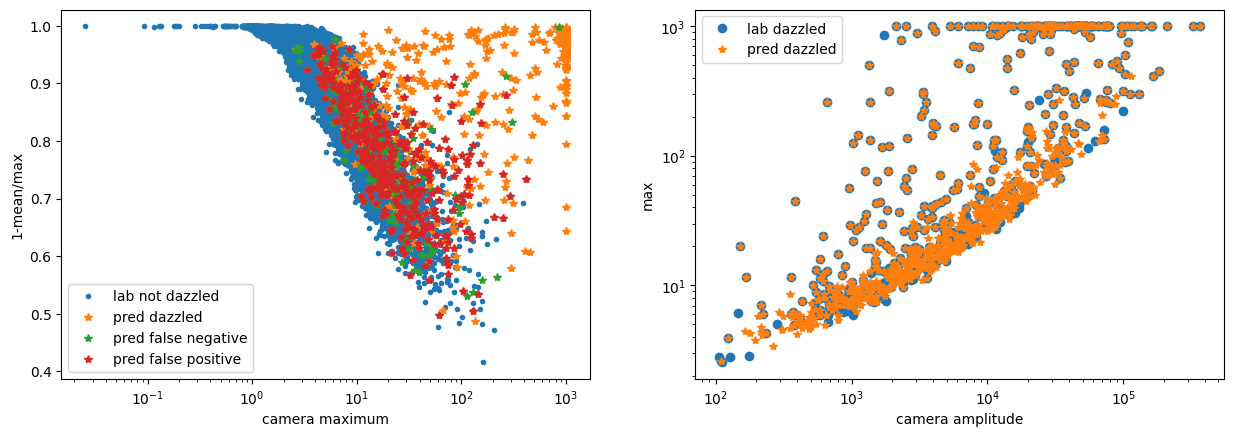

In [39]:
test_d = data_in[sep:]

lab_bl = test_d[np.where(pred_lab==1)]
lab_not_bl = test_d[np.where(pred_lab==0)]
pred_bl = test_d[np.where(pred_dec==1)]
pred_not_bl = test_d[np.where(pred_dec==0)]
pred_fn = test_d[np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0))]
pred_fp = test_d[np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1))]

fig, ax = plt.subplots(1,2)
ax[0].plot(Max(lab_not_bl), Ratio(lab_not_bl), '.', label='lab not dazzled')
ax[0].plot(Max(pred_bl), Ratio(pred_bl), '*', label='pred dazzled')
ax[0].plot(Max(pred_fn), Ratio(pred_fn), '*', label='pred false negative')
ax[0].plot(Max(pred_fp), Ratio(pred_fp), '*', label='pred false positive')
ax[0].set_xscale('log')
ax[0].set_xlabel('camera maximum')
ax[0].set_ylabel('1-mean/max')
ax[0].legend()

ax[1].plot(Amp(lab_bl), Max(lab_bl), 'o', label='lab dazzled')
ax[1].plot(Amp(pred_bl), Max(pred_bl), '*', label='pred dazzled')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].set_ylabel('max')
ax[1].legend()

fig.set_figwidth(15)

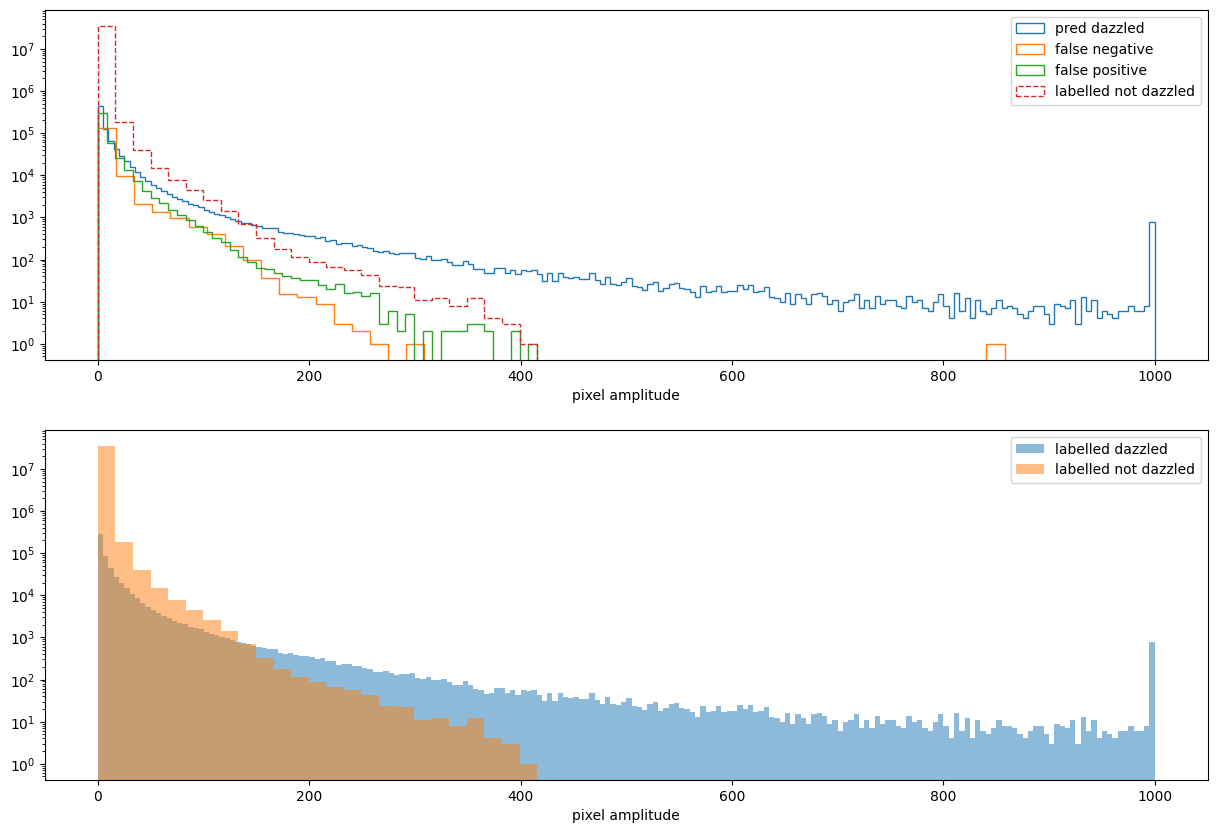

In [40]:
fig, ax = plt.subplots(2,1)

fig.set_figwidth(15)
fig.set_figheight(10)
ax[0].hist(pred_bl.reshape(-1,1), 200, histtype='step', label='pred dazzled');
ax[0].hist(pred_fn.reshape(-1,1), 50, histtype='step', label='false negative');
ax[0].hist(pred_fp.reshape(-1,1), 50, histtype='step', label='false positive');
ax[0].hist(lab_not_bl.reshape(-1,1), 25, histtype='step', ls='--', label='labelled not dazzled');ax[0].set_yscale('log')
ax[0].set_xlabel('pixel amplitude')
ax[0].legend()


ax[1].hist(lab_bl.reshape(-1,1), 200, alpha=0.5, label='labelled dazzled');
ax[1].hist(lab_not_bl.reshape(-1,1), 25, alpha=0.5, label='labelled not dazzled');
ax[1].set_yscale('log')
ax[1].set_xlabel('pixel amplitude')
ax[1].legend()

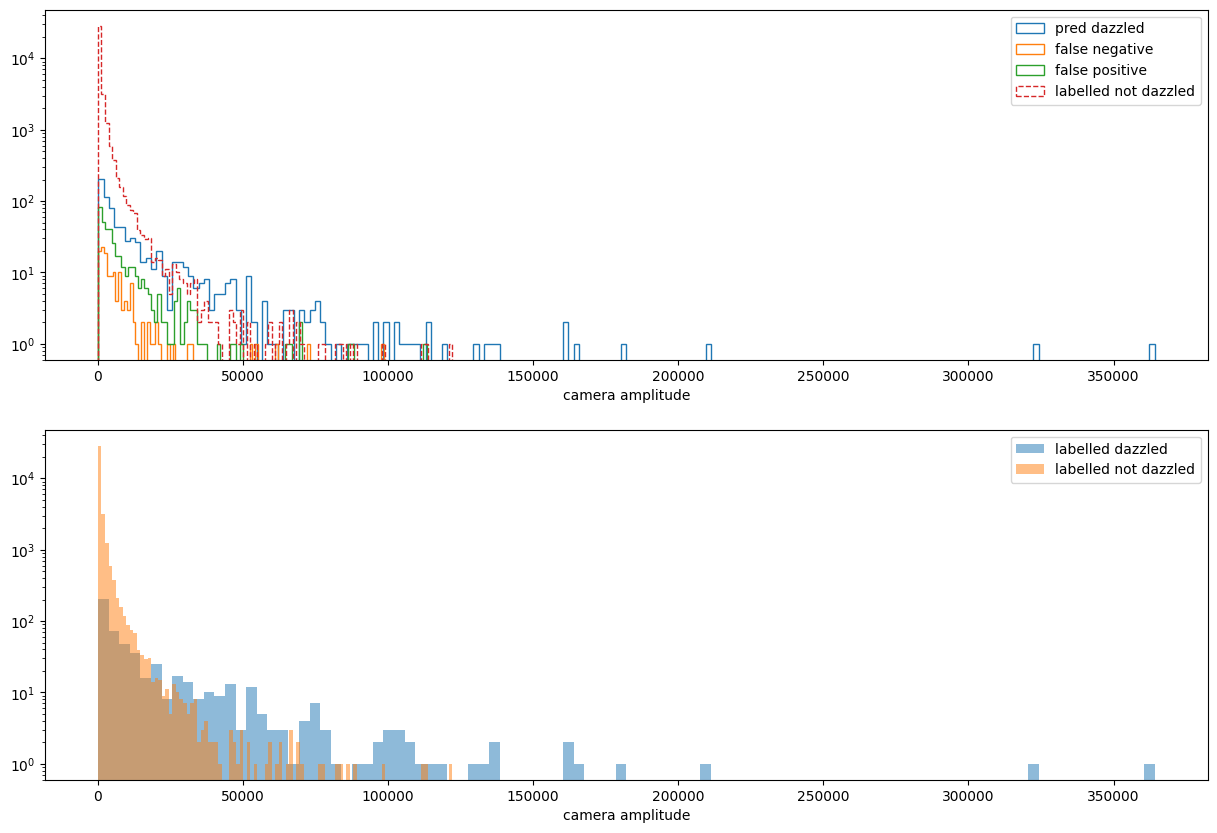

In [41]:
fig, ax = plt.subplots(2,1)
fig.set_figwidth(15)
fig.set_figheight(10)

ax[0].hist(Amp(pred_bl).reshape(-1,1), 200, histtype='step', label='pred dazzled');
ax[0].hist(Amp(pred_fn).reshape(-1,1), 100, histtype='step', label='false negative');
ax[0].hist(Amp(pred_fp).reshape(-1,1), 100, histtype='step', label='false positive');
ax[0].hist(Amp(lab_not_bl), 100, histtype='step', ls='--', label='labelled not dazzled');
ax[0].set_yscale('log')
ax[0].set_xlabel('camera amplitude')
ax[0].legend()

ax[1].hist(Amp(lab_bl).reshape(-1,1), 100, alpha=0.5, label='labelled dazzled');
ax[1].hist(Amp(lab_not_bl).reshape(-1,1), 100, alpha=0.5, label='labelled not dazzled');
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].legend()

In [42]:
save_model = False
if save_model:
    model_json = model.to_json()
    with open('model_highRoc.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('model_highRoc.h5')